In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.basics import *

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [6]:
path = Path('./SegNet-Tutorial/CamVid')

In [7]:
path.ls()

[PosixPath('SegNet-Tutorial/CamVid/models'),
 PosixPath('SegNet-Tutorial/CamVid/valannot'),
 PosixPath('SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('SegNet-Tutorial/CamVid/val'),
 PosixPath('SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('SegNet-Tutorial/CamVid/test'),
 PosixPath('SegNet-Tutorial/CamVid/train'),
 PosixPath('SegNet-Tutorial/CamVid/testannot')]

# Data

In [8]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08039.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08105.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08081.png')]

In [9]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08039.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08105.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08081.png')]

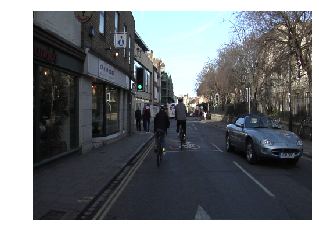

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

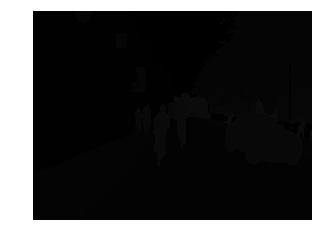

In [11]:
anno_f = Path(str(img_f.parent)+'annot')/img_f.name
anno = open_image(anno_f)
anno.show(figsize=(5,5))

In [12]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

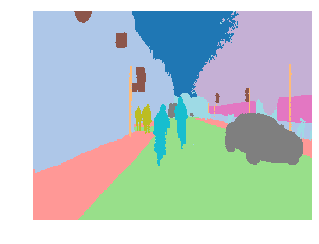

In [13]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [14]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([360, 480]), tensor([[[ 1,  1,  1,  ...,  5,  5,  5],
          [ 1,  1,  1,  ...,  5,  5,  5],
          [ 1,  1,  1,  ...,  5,  5,  5],
          ...,
          [ 4,  4,  4,  ...,  3,  3,  3],
          [ 4,  4,  4,  ...,  3,  3,  3],
          [ 4,  4,  4,  ...,  3,  3,  3]]]))

# Getting them into a DataBunch

In [15]:
bs, size = 8, src_size//2

In [16]:
src = (SegmentationItemList.from_folder(path)
      .split_by_folder(valid='val')
      .label_from_func(get_y_fn, classes=codes))

In [17]:
src

LabelLists;

Train: LabelList
y: SegmentationLabelList (367 items)
[ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480)]...
Path: SegNet-Tutorial/CamVid
x: SegmentationItemList (367 items)
[Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480)]...
Path: SegNet-Tutorial/CamVid;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480)]...
Path: SegNet-Tutorial/CamVid
x: SegmentationItemList (101 items)
[Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480)]...
Path: SegNet-Tutorial/CamVid;

Test: None

In [18]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

You can deactivate this warning by passing `no_check=True`.


/home/luan/anaconda3/lib/python3.7/site-packages/fastai/basic_data.py:226: UserWarning: There seems to be something wrong with your dataset, can't access any element of self.train_ds.
Tried: 86,71,117,361,124...
  warn(warn_msg)


In [19]:
data.show_batch(2, figsize=(7,7))

ValueError: Traceback (most recent call last):
  File "/home/luan/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/luan/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 567, in __getitem__
    x = x.apply_tfms(self.tfms, **self.tfmargs)
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/vision/image.py", line 118, in apply_tfms
    else: x = tfm(x)
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/vision/image.py", line 506, in __call__
    return self.tfm(x, *args, **{**self.resolved, **kwargs}) if self.do_run else x
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/vision/image.py", line 453, in __call__
    if args: return self.calc(*args, **kwargs)
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/vision/image.py", line 458, in calc
    if self._wrap: return getattr(x, self._wrap)(self.func, *args, **kwargs)
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/vision/image.py", line 162, in lighting
    self.logit_px = func(self.logit_px, *args, **kwargs)
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/vision/image.py", line 200, in logit_px
    if self._logit_px is None: self._logit_px = logit_(self.px)
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/vision/image.py", line 140, in px
    self.refresh()
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/vision/image.py", line 127, in refresh
    self._px = _grid_sample(self._px, self.flow, **self.sample_kwargs)
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/vision/image.py", line 523, in _grid_sample
    return F.grid_sample(x[None], coords, mode=mode, padding_mode=padding_mode)[0]
  File "/home/luan/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py", line 2092, in grid_sample
    raise ValueError("padding_mode needs to be 'zeros' or 'border', but got {}".format(padding_mode))
ValueError: padding_mode needs to be 'zeros' or 'border', but got reflection


# Model

In [18]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [19]:
name2id

{'Sky': 0,
 'Building': 1,
 'Pole': 2,
 'Road': 3,
 'Sidewalk': 4,
 'Tree': 5,
 'Sign': 6,
 'Fence': 7,
 'Car': 8,
 'Pedestrian': 9,
 'Cyclist': 10,
 'Void': 11}

In [20]:
metrics=acc_camvid
wd=1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


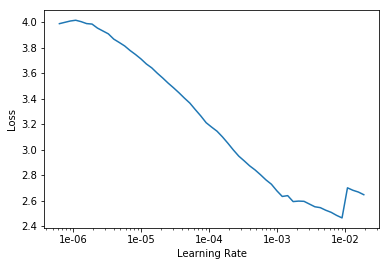

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr = 1e-04

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,2.211802,1.885360,0.521265
2,1.218251,0.903943,0.774658
3,0.790637,0.689406,0.797918
4,0.626730,0.625804,0.825716
5,0.557899,0.509035,0.853801
6,0.489047,0.459992,0.863801
7,0.453633,0.422078,0.870812
8,0.423413,0.390009,0.875403
9,0.392047,0.363550,0.890409
10,0.337426,0.310844,0.909139


In [25]:
learn.save('stage-1')

In [28]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (367 items)
[ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480)]...
Path: SegNet-Tutorial/CamVid
x: SegmentationItemList (367 items)
[Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480)]...
Path: SegNet-Tutorial/CamVid;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480)]...
Path: SegNet-Tutorial/CamVid
x: SegmentationItemList (101 items)
[Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480)]...
Path: SegNet-Tutorial/CamVid;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [29]:
#Couple more epoches
learn.fit_one_cycle(7, slice(lr))

epoch,train_loss,valid_loss,acc_camvid
1,0.323444,0.324453,0.904223
2,0.340576,0.349998,0.891146
3,0.317952,0.424874,0.875630
4,0.297210,0.293980,0.913970
5,0.285655,0.266865,0.919068
6,0.255351,0.271732,0.920263
7,0.243382,0.263412,0.921938


In [30]:
learn.save('stage-1-1')

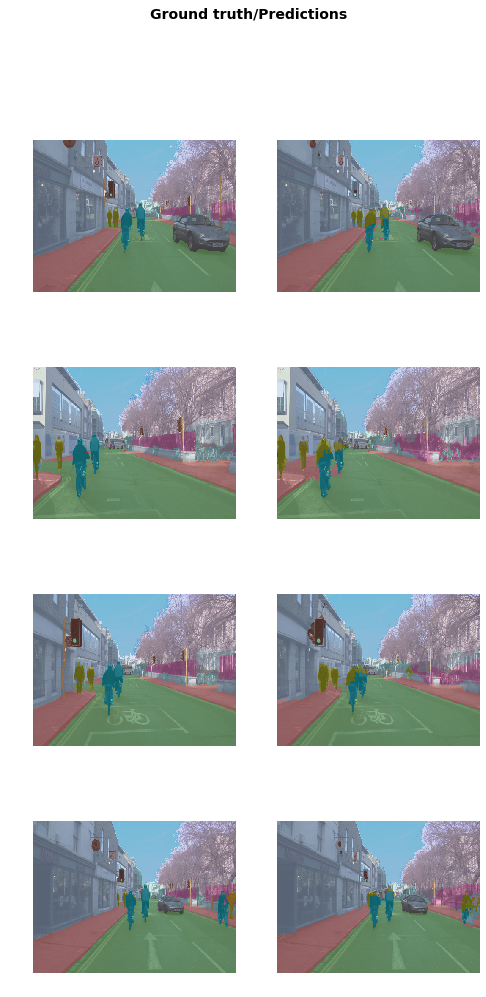

In [32]:
learn.show_results(rows=5)

In [36]:
learn.load('stage-1-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (367 items)
[ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480)]...
Path: SegNet-Tutorial/CamVid
x: SegmentationItemList (367 items)
[Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480)]...
Path: SegNet-Tutorial/CamVid;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480)]...
Path: SegNet-Tutorial/CamVid
x: SegmentationItemList (101 items)
[Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480)]...
Path: SegNet-Tutorial/CamVid;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [37]:
learn.unfreeze()

In [38]:
lrs = slice(lr/400, lr/4)

In [39]:
learn.fit_one_cycle(15, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.243271,0.263082,0.922035
2,0.244371,0.265037,0.923098
3,0.243306,0.265721,0.920491
4,0.239633,0.266907,0.920507
5,0.243475,0.263081,0.923162
6,0.234001,0.263265,0.923540
7,0.238563,0.258074,0.924374
8,0.239549,0.263548,0.922000
9,0.238375,0.254033,0.925752
10,0.232019,0.272876,0.917643


In [40]:
learn.save('stage-2')

# Wrong notebook :(. Do it again

In [5]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/luan/.fastai/data/camvid/images'),
 PosixPath('/home/luan/.fastai/data/camvid/labels'),
 PosixPath('/home/luan/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/luan/.fastai/data/camvid/codes.txt')]

In [6]:
path_lbl = path/'labels'
path_img = path/'images'

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/luan/.fastai/data/camvid/images/0006R0_f01860.png'),
 PosixPath('/home/luan/.fastai/data/camvid/images/Seq05VD_f04980.png'),
 PosixPath('/home/luan/.fastai/data/camvid/images/0016E5_08039.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/luan/.fastai/data/camvid/labels/0016E5_08490_P.png'),
 PosixPath('/home/luan/.fastai/data/camvid/labels/Seq05VD_f01230_P.png'),
 PosixPath('/home/luan/.fastai/data/camvid/labels/Seq05VD_f05010_P.png')]

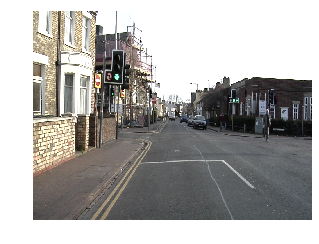

In [9]:
# Sample image
img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

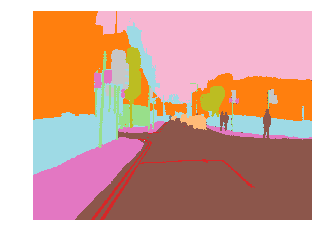

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [14]:
size = src_size//2
bs = 4

In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
src

LabelLists;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/luan/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/luan/.fastai/data/camvid/images;

Test: None

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

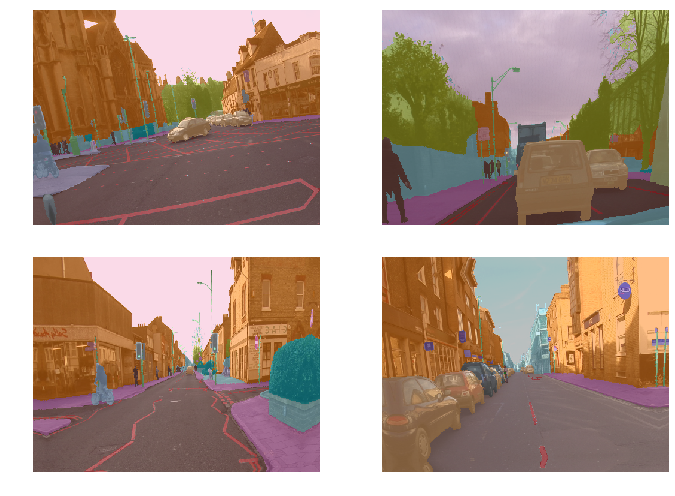

In [18]:
data.show_batch(2, figsize=(10,7))

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics=acc_camvid
# metrics=accuracy

In [21]:
wd = 1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04


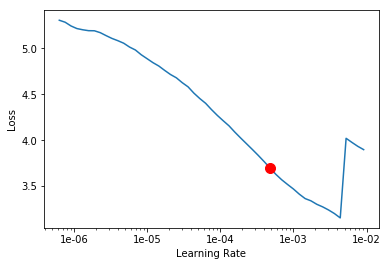

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lr = 4e-04

In [25]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,1.382071,0.964391,0.785365
2,0.861718,0.733176,0.829786
3,0.679595,0.596247,0.842809
4,0.616262,0.627355,0.816504
5,0.601185,0.662153,0.832261
6,0.521482,0.428395,0.885450
7,0.513716,0.405562,0.892753
8,0.490697,0.356345,0.898494
9,0.451220,0.399567,0.890152
10,0.363713,0.297938,0.913909


In [26]:
learn.save('stage-1')

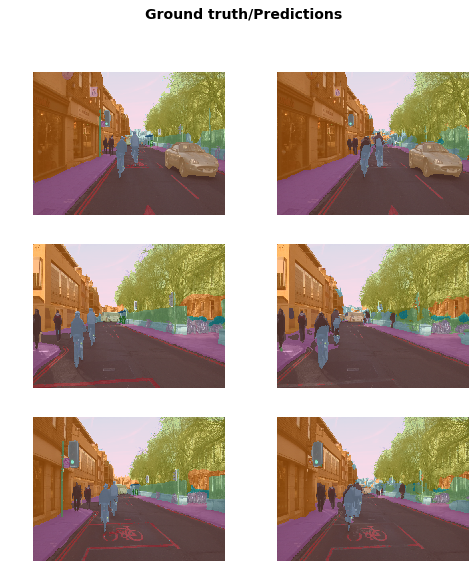

In [27]:
learn.show_results(rows=3, figsize=(8,9))

In [28]:
learn.unfreeze()

In [29]:
lrs = slice(lr/400,lr/4)

In [30]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.319819,0.294471,0.914426
2,0.319204,0.284234,0.917941
3,0.320299,0.277665,0.920797
4,0.313524,0.289135,0.916238
5,0.306823,0.297975,0.912896
6,0.302479,0.298298,0.912032
7,0.295714,0.286908,0.916269
8,0.287804,0.277616,0.920512
9,0.286069,0.292678,0.915709
10,0.269957,0.278043,0.921389


In [31]:
learn.save('stage-2')

NameError: name 'gpu_mem_get_free_no_cache' is not defined